В этом примере показано, как использовать **KernelPCA** для шумоподавления изображений. Короче говоря, мы используем функцию аппроксимации, изученную во время, fit для восстановления исходного изображения.

Сравним результаты с точной реконструкцией с использованием PCA.

Мы будем использовать набор данных USPS digits

In [10]:
#Загрузите набор данных через OpenML 
#Наборы данных USPS digits доступны в OpenML. Мы используем fetch_openml, чтобы получить этот набор данных. Кроме
#того, мы нормализуем набор данных таким образом, чтобы все значения пикселей находились в диапазоне (0, 1).
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

X, y = fetch_openml(data_id=41082, as_frame=False, return_X_y=True, parser="pandas")
X = MinMaxScaler().fit_transform(X)

Идея будет состоять в том, чтобы изучить основу PCA (с ядром и без него) на зашумленных изображениях, а затем использовать эти модели для восстановления и удаления шума из этих изображений.

Таким образом, мы разделили наш набор данных на набор для обучения и тестирования, состоящий из 1000 образцов для обучения и 100 образцов для тестирования. Эти изображения не содержат шума, и мы будем использовать их для оценки эффективности подходов шумоподавления. Кроме того, мы создаем копию исходного набора данных и добавляем гауссов шум.

Идея этого приложения состоит в том, чтобы показать, что мы можем удалять шумы с поврежденных изображений, изучая основу PCA на некоторых неповрежденных изображениях. Для решения этой проблемы мы будем использовать как PCA, так и PCA на основе ядра.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=0, train_size=1_000, test_size=100
)

rng = np.random.RandomState(0)
noise = rng.normal(scale=0.25, size=X_test.shape)
X_test_noisy = X_test + noise

noise = rng.normal(scale=0.25, size=X_train.shape)
X_train_noisy = X_train + noise

Кроме того, мы создадим вспомогательную функцию для качественной оценки реконструкции изображения путем построения тестовых изображений.

In [17]:
import matplotlib.pyplot as plt


def plot_digits(X, title):
    """Небольшая вспомогательная функция для построения 100 цифр."""
    fig, axs = plt.subplots(nrows=10, ncols=10, figsize=(8, 8))
    for img, ax in zip(X, axs.ravel()):
        ax.imshow(img.reshape((16, 16)), cmap="Greys")
        ax.axis("off")
    fig.suptitle(title, fontsize=24)

Кроме того, мы будем использовать среднеквадратичную ошибку (MSE) для количественной оценки реконструкции изображения.

Давайте сначала посмотрим, чтобы увидеть разницу между изображением без шума и изображением с шумом. Мы проверим тестовый набор в этом отношении.

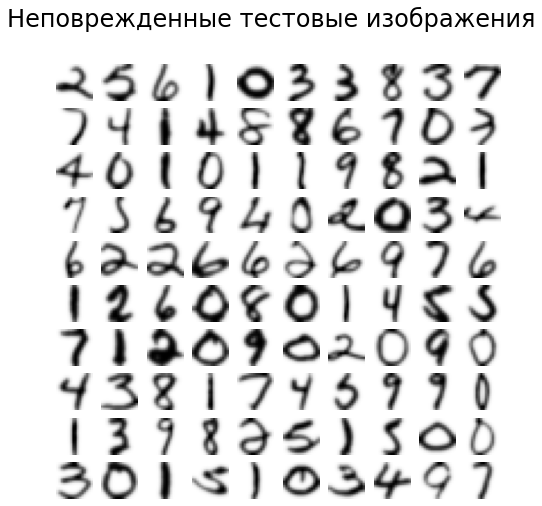

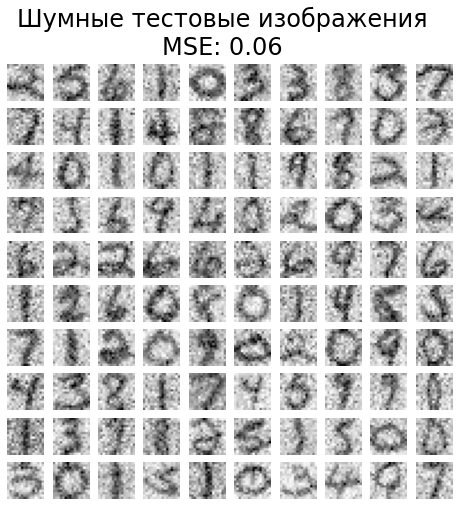

In [13]:
plot_digits(X_test, "Неповрежденные тестовые изображения")
plot_digits(
    X_test_noisy, f"Шумные тестовые изображения\nMSE: {np.mean((X_test - X_test_noisy) ** 2):.2f}"
)

In [18]:
#Изучите PCAосновы
#Теперь мы можем изучить нашу основу PCA, используя как линейный PCA, так и PCA ядра, использующий ядро ​​радиальной
#базисной функции (RBF).
from sklearn.decomposition import PCA, KernelPCA

pca = PCA(n_components=32)
kernel_pca = KernelPCA(
    n_components=400, kernel="rbf", gamma=1e-3, fit_inverse_transform=True, alpha=5e-3
)

pca.fit(X_train_noisy)
_ = kernel_pca.fit(X_train_noisy)

**Реконструкция и удаление шумов из тестовых изображений**

Теперь мы можем преобразовать и реконструировать зашумленный тестовый набор. Так как мы использовали меньше компонентов, чем количество исходных признаков, мы получим приближение к исходному набору. Действительно, отбрасывая компоненты, в наименьшей степени объясняющие дисперсию PCA, мы надеемся удалить шум. Аналогичное мышление происходит в ядре PCA; однако мы ожидаем более качественной реконструкции, поскольку используем нелинейное ядро ​​для изучения основы PCA и гребень ядра для изучения функции отображения.

In [19]:
X_reconstructed_kernel_pca = kernel_pca.inverse_transform(
    kernel_pca.transform(X_test_noisy)
)
X_reconstructed_pca = pca.inverse_transform(pca.transform(X_test_noisy))

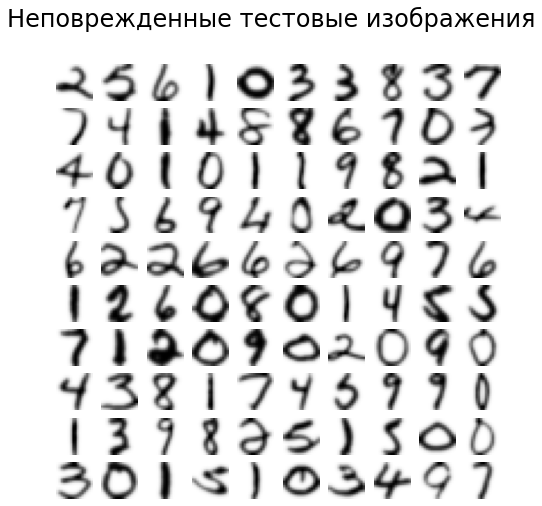

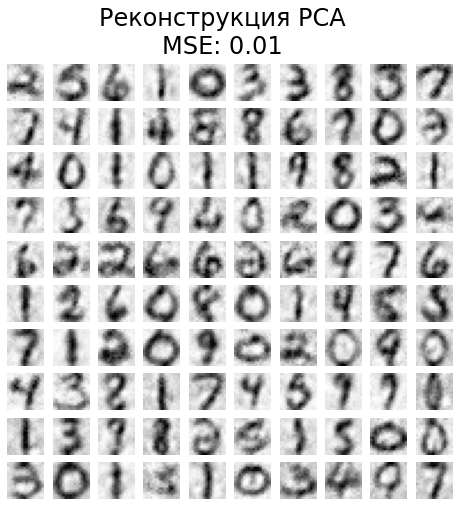

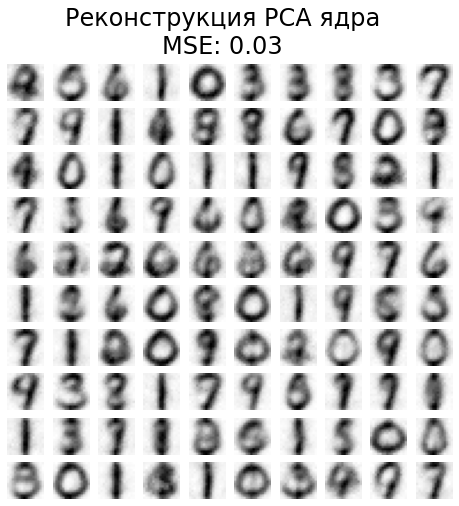

In [20]:
plot_digits(X_test, "Неповрежденные тестовые изображения")
plot_digits(
    X_reconstructed_pca,
    f"Реконструкция PCA\nMSE: {np.mean((X_test - X_reconstructed_pca) ** 2):.2f}",
)
plot_digits(
    X_reconstructed_kernel_pca,
    "Реконструкция PCA ядра\n"
    f"MSE: {np.mean((X_test - X_reconstructed_kernel_pca) ** 2):.2f}",
)

PCA имеет более низкую MSE, чем PCA ядра. Однако качественный анализ может не отдавать предпочтение PCA вместо PCA ядра. Мы видим, что ядро ​​PCA способно удалить фоновый шум и обеспечить более плавное изображение.

Однако следует отметить, что результаты шумоподавления с помощью ядра PCA будут зависеть от параметров n_components, gammaи alpha.